# File reduction
Since the original file is over 5 GB, pandas struggles to open it all at once on a typical laptop with 8 GB RAM. 
As a solution, this program cuts it into chunks, groups events by the second (we don't care about millisecond precision of the event) and saves a new file.

In [3]:
from scipy import stats
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def decoupling_time(r):
    '''
    This will output in this format: 1970-08-22 19:25:00 
    '''
    s = str(r)
    year, month, day, hour, minute, second = s[:4], s[4:6], s[6:8], s[8:10], s[10:12], s[12:14]
    
    return '-'.join([year, month, day]) + ' ' + ':'.join([hour, minute, second])
#decoupling_time(20201117235750093)


In [5]:
filename = "Raw Data/touchevent.csv"
final_data = pd.DataFrame()
#different chunk sizes, one_hundred is for tests. 
five_million = 5*10**6
three_million = 3*10**6
one_hundred = 10**2
c = 0
for chunk in tqdm(pd.read_csv(filename, chunksize=three_million)): 
    #deep copy 
    temp = chunk[['userid','day']]
    
    #turning now time from raw to machine readable ; #every minute has a specific count                                         
    shortened_times = pd.to_datetime(chunk['timestamp'].apply(
        decoupling_time), yearfirst=True).dt.floor('s')
    temp.insert(2, 'timestamp', shortened_times)
    #attenzione: il conteggio potrebbe essere meglio rappresentato
    # da una misura di massimo un numero di tocchi al secondo, oltre 
    #la quale si è outliers o c'è un errore nei dati; quando viene 
    # portato al minuto, la somma può essere divisa per secondi (60)
    
    #grouping 
    df_grouped = temp.groupby(['userid', 'day','timestamp' ]).size()                                         
    df_grouped = df_grouped.reset_index(name='touches')
    df_grouped.day = df_grouped.day.apply(lambda x: str(x)[:4]+'/'+str(x)[4:6]+'/'+str(x)[6:])
    df_grouped.day = pd.to_datetime(df_grouped.day, yearfirst=True)
    
    # ONLY NOVEMBER 
    '''
    df_grouped.day = df_grouped.day.apply(lambda x: True if str(x)[4:6] == "11" else False) #only november 
    df_grouped.rename(columns={"day": "first_two_weeks"}, inplace=True)
    df_grouped = df_grouped[df_grouped.first_two_weeks]   #this does the selection
    '''
    #df_grouped = df_grouped.drop(['first_two_weeks'], axis='columns')
    
    #appending to a global df
    final_data = pd.concat([final_data, df_grouped], ignore_index=True) 
    c += 1  #break during tests
    if c == 100:
        break
print(f"There were originally about {c*three_million:,} rows. Now there are exactly {final_data.shape[0]:,}")
print("File reduction is completed.")
final_data.to_csv('Processed Data/touch_sensor_unclean.csv')
print('The file was saved onto the current directory.')

0it [00:00, ?it/s]/tmp/ipykernel_131756/2225915510.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  shortened_times = pd.to_datetime(chunk['timestamp'].apply(
0it [00:08, ?it/s]


DateParseError: Unknown datetime string format, unable to parse: 2020--1-1- 22: 0:0:, at position 0

[Text(0, 0, '10/11'),
 Text(1, 0, '11/11'),
 Text(2, 0, '12/11'),
 Text(3, 0, '13/11'),
 Text(4, 0, '14/11'),
 Text(5, 0, '15/11'),
 Text(6, 0, '16/11'),
 Text(7, 0, '17/11'),
 Text(8, 0, '18/11'),
 Text(9, 0, '19/11'),
 Text(10, 0, '20/11'),
 Text(11, 0, '21/11'),
 Text(12, 0, '22/11'),
 Text(13, 0, '23/11'),
 Text(14, 0, '24/11'),
 Text(15, 0, '25/11'),
 Text(16, 0, '26/11'),
 Text(17, 0, '27/11'),
 Text(18, 0, '28/11'),
 Text(19, 0, '29/11'),
 Text(20, 0, '30/11'),
 Text(21, 0, '01/12'),
 Text(22, 0, '02/12'),
 Text(23, 0, '03/12'),
 Text(24, 0, '04/12'),
 Text(25, 0, '05/12'),
 Text(26, 0, '06/12'),
 Text(27, 0, '07/12'),
 Text(28, 0, '08/12'),
 Text(29, 0, '09/12'),
 Text(30, 0, '10/12'),
 Text(31, 0, '11/12'),
 Text(32, 0, '12/12'),
 Text(33, 0, '13/12'),
 Text(34, 0, '14/12'),
 Text(35, 0, '15/12'),
 Text(36, 0, '16/12')]

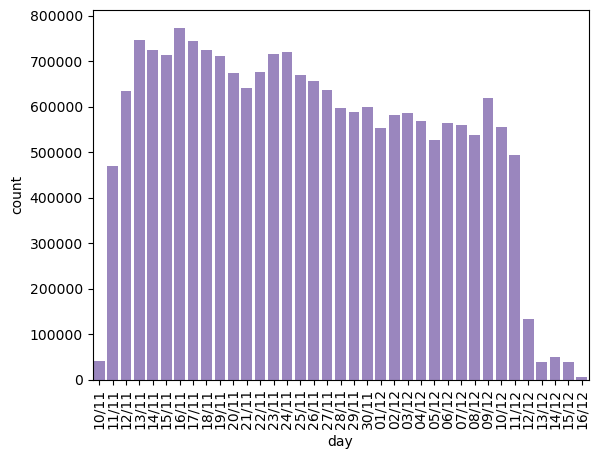

In [30]:
# To run this, most of this cell has to be unblocked
# and needs to be put hashtags all over the "ONLY FIRST TWO WEEKS" block in the previous for loop.


days_in_total = final_data.day.value_counts().sort_index()
raw_data_days_frequency.to_csv('Processed Data/total_days_and_frequency.csv')
table=days_in_total
#table = pd.read_csv("Processed Data/total_days_and_frequency.csv").sort_index()
g = sns.barplot(data=table, x=table['day'], y=table['count'], color='#977dc7')
g.set_xticklabels(labels=table.day.apply(lambda x: str(x)[-2:] + '/' + str(x)[-5:-3]),rotation=90)
# It seems like from 12th of November 'till 11th of December there was most activity. 
plt.show()

# Making sure there are no mistakes.
When grouping by second, because of the massive size of the original dataset, there can be mistakes when passing from one iteration to the other. For example, two observations with the same second but parsed in two different iterations may not be grouped in the same second. The fastest solution is to re-run the code on the parsed, processed new file as this time no _for_ loop is needed.

In [5]:
%time
filename = 'Processed Data/touch_sensor_unclean.csv'
temp = pd.read_csv(filename)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


In [7]:
%time
shortened_times = pd.to_datetime(temp.timestamp, yearfirst=True).dt.floor('s')
temp.timestamp = shortened_times
df_grouped = temp.groupby(['userid', 'timestamp', 'day']).size()                                         
df_grouped = df_grouped.reset_index(name='touches')

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.9 µs


In [10]:
f"{df_grouped.shape[0]:,}"  #Should be 19,859,138

'19,859,138'

In [11]:
df_grouped.to_csv(filename)